# Set-up

## Imports

In [31]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import plotly.express as px
import pickle

import numpy as np
from tqdm.notebook import trange

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

# Custom
from utils import geometric_median, geometric_medoid, month_to_season, plot_components, normalize_curves, align_components
from blind_separation import get_D

In [32]:
sns.set_theme()
colors = sns.color_palette("deep")

## Parameters

In [38]:
n_components = 5
n_runs = 1000
alpha = 3e-10
beta = 1

# Input
load_data_path = 'data/daily_curves_2020_to_2022.csv'
results_path = 'data/lcnmf_ens_2020_to_2022.npz'
# Output
cluster_opt_path = 'data/lcnmf_ens_opt_2020_to_2022.npz'

colormap = ListedColormap([colors[k] for k in range(n_components)])

daytype_order = [
    'Monday',
    'Working day',
    'Saturday',
    'Holiday'
]

season_order = ['Spring', 'Summer', 'Fall', 'Winter']
season_palette = ['#77dd77', '#ffdb58', '#FF8C00', '#4682B4']

source_names = [f'$S_{k+1}$' for k in range(n_components)]

# Read

## Data matrix $X$

In [34]:
input_df = pd.read_csv(load_data_path, index_col=0)
n = len(input_df)
print(n)
input_df.head(3)

1096


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2020-01-01_Holiday,24.300000,23.308000,22.157999,20.786000,19.891000,19.947001,20.578999,21.473999,21.413001,22.792,...,24.355000,24.475,27.938999,29.663000,30.459000,30.347000,29.180,27.406000,24.879000,22.212999
Italy_2020-01-02_Working day,22.212999,20.395000,19.276000,19.059001,19.167999,20.177000,23.560000,28.026999,31.600000,35.583,...,34.867002,35.579,39.744001,40.361000,40.117000,38.273000,35.756,32.371000,28.863001,25.324000
Italy_2020-01-03_Working day,25.324000,23.275001,21.741000,21.228999,21.438000,22.064999,25.270000,30.257000,34.130000,37.619,...,36.133999,37.081,40.802001,41.079001,40.668001,38.369999,35.184,31.951999,28.347001,25.134999


In [35]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
unit_info['season'] = unit_info.month.astype(int).map(month_to_season)
df = pd.concat([input_df, unit_info], axis=1)
print(len(df))
df.head(3)

1096


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,region,year,month,daytype,season
Italy_2020-01-01_Holiday,24.300000,23.308000,22.157999,20.786000,19.891000,19.947001,20.578999,21.473999,21.413001,22.792,...,30.347000,29.180,27.406000,24.879000,22.212999,Italy,2020,01,Holiday,Winter
Italy_2020-01-02_Working day,22.212999,20.395000,19.276000,19.059001,19.167999,20.177000,23.560000,28.026999,31.600000,35.583,...,38.273000,35.756,32.371000,28.863001,25.324000,Italy,2020,01,Working day,Winter
Italy_2020-01-03_Working day,25.324000,23.275001,21.741000,21.228999,21.438000,22.064999,25.270000,30.257000,34.130000,37.619,...,38.369999,35.184,31.951999,28.347001,25.134999,Italy,2020,01,Working day,Winter


In [36]:
X = df.drop(unit_info.columns, axis=1)
X = normalize_curves(X)
p = len(X.columns)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
Italy_2020-01-01_Holiday,0.040982,0.039309,0.037369,0.035055,0.033546,0.033640,0.034706,0.036216,0.036113,0.038439,...,0.041075,0.041277,0.047119,0.050026,0.051369,0.051180,0.049212,0.046220,0.041958,0.037462
Italy_2020-01-02_Working day,0.029836,0.027394,0.025891,0.025600,0.025746,0.027102,0.031646,0.037646,0.042445,0.047795,...,0.046833,0.047789,0.053384,0.054212,0.053885,0.051408,0.048027,0.043480,0.038768,0.034015
Italy_2020-01-03_Working day,0.032524,0.029893,0.027922,0.027265,0.027533,0.028339,0.032455,0.038860,0.043834,0.048315,...,0.046408,0.047624,0.052403,0.052759,0.052231,0.049279,0.045187,0.041037,0.036407,0.032281
Italy_2020-01-04_Saturday,0.035505,0.032732,0.031074,0.030431,0.030038,0.031102,0.033951,0.038281,0.041585,0.045738,...,0.043068,0.043740,0.049297,0.051954,0.053135,0.051134,0.046995,0.043196,0.039101,0.034850
Italy_2020-01-05_Holiday,0.038522,0.034876,0.032662,0.031490,0.031316,0.031853,0.033533,0.036586,0.037979,0.041645,...,0.041873,0.042782,0.047938,0.051710,0.053156,0.051982,0.048822,0.045577,0.041847,0.037617


## LCNMF results

In [39]:
# Load the arrays from the .npz file
data = np.load(results_path)
# Access the arrays
C_results = data['C_results']
S_results = data['S_results']
iterations = data['iterations']
loss_nmf = data['loss_nmf']
loss_constraint_c = data['loss_constraint_c']
loss_constraint_s = data['loss_constraint_s']
print('Loaded ', results_path)

# Load the LCNMF objects
estimator_path = results_path.replace('.npz', '.pkl')
with open(estimator_path, 'rb') as file:
    estimators = pickle.load(file)
print('Loaded ', estimator_path)

Loaded  data/lcnmf_ens_2020_to_2022.npz
Loaded  data/lcnmf_ens_2020_to_2022.pkl


# Inspect results

## Number of iterations

<Axes: >

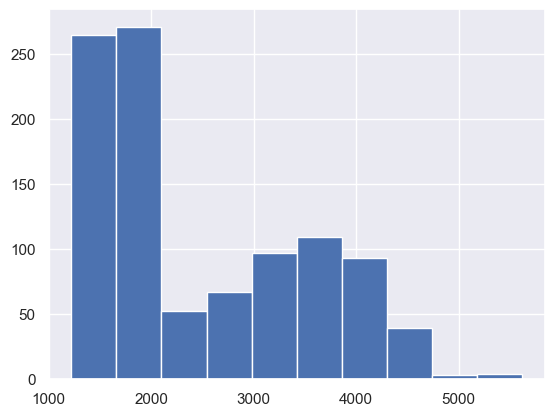

In [40]:
pd.Series(iterations).hist()

## Total loss

<Axes: >

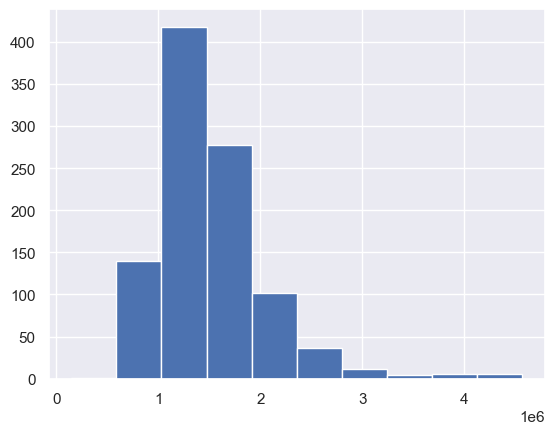

In [41]:
pd.Series(loss_nmf + loss_constraint_c + loss_constraint_s).hist()

## Individual losses

In [42]:
losses_df = pd.DataFrame({
    'loss_nmf': loss_nmf,
    'loss_constraint_c': loss_constraint_c,
    'loss_constraint_s': loss_constraint_s,
})
losses_df

,loss_nmf,loss_constraint_c,loss_constraint_s
0,0.019168,8.908112e+05,5.462303e-08
1,0.022330,1.680153e+06,5.275222e-07
2,0.012478,1.046559e+06,9.544710e-08
3,0.021615,1.947932e+06,2.824125e-07
4,0.019845,1.203470e+06,1.068478e-07
...,...,...,...
995,0.021623,1.265553e+06,1.152837e-07
996,0.012563,1.845417e+06,6.672407e-07
997,0.012264,1.413941e+06,1.659900e-07
998,0.021260,1.423007e+06,2.112267e-07


In [43]:
# Create 3D Scatter Plot
fig = px.scatter_3d(
    losses_df, 
    x='loss_nmf', 
    y='loss_constraint_c', 
    z='loss_constraint_s', 
    title="Solutions in the losses space",
)

fig.update_layout(
    width=600,
    height=600,
)

fig.update_traces(marker=dict(size=3))

fig.show()

## Check that the sources have unit $L_1$-norm

<Axes: >

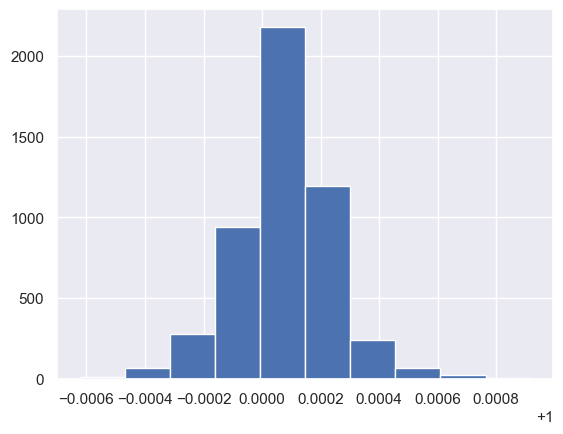

In [44]:
D = get_D(p)
# We swap second and third dimension to have a correct reshape and get a 2d matrix where each row is a curve
flatten_results = S_results.transpose((0, 2, 1)).reshape((n_components * n_runs, p))
source_norms = pd.Series(flatten_results.dot(D).squeeze())
source_norms.hist()

This constraint is very well respected (not surprising) so we could actually could discard the loss term associated to S in the clustering (but here we keep it)

# Cluster the solutions in the losses space

Using DBSCAN

In [45]:
losses_scaled = StandardScaler().fit_transform(losses_df)

# Fit Nearest Neighbors model
neighbors = NearestNeighbors(n_neighbors=losses_scaled.shape[1])  # rule of thumb
neighbors_fit = neighbors.fit(losses_scaled)
distances, indices = neighbors_fit.kneighbors(losses_scaled)

# Sort distances
distances = np.sort(distances[:, 1])

# plt.plot(distances)
# plt.title("k-NN Distance Plot")
# plt.xlabel("Points sorted by distance")
# plt.ylabel("2nd Nearest Neighbor Distance")
# plt.show()

# Create a DataFrame for Plotly Express
distances_df = pd.DataFrame({
    "Index": range(len(distances)),  # Indices of sorted distances
    "Distance": distances           # Sorted distances
})

# Create the plot with Plotly Express
fig = px.line(
    distances_df, 
    x="Index", 
    y="Distance", 
    title="k-NN Distance Plot", 
    labels={"Index": "Points sorted by distance", "Distance": "2nd Nearest Neighbor Distance"},
    width=600,  # Adjust plot width
    height=400  # Adjust plot height
)

# Show the plot
fig.show()

Let's try with `minPts=4` (at least) and `eps=0.5` (2-NN distance value at which the noise starts).

In [46]:
dbscan = DBSCAN(eps=0.5, min_samples=5) # best setting with min_samples=5 finally
dbscan.fit(losses_scaled)
losses_df['cluster'] = dbscan.labels_
losses_df['cluster'] = losses_df.cluster.replace({-1: np.nan})

# Create 3D Scatter Plot
fig = px.scatter_3d(
    losses_df, 
    x='loss_nmf', 
    y='loss_constraint_c', 
    z='loss_constraint_s',
    color='cluster',
    title="Solutions in the losses space",
)

fig.update_layout(
    width=600,
    height=600,
)

fig.update_traces(marker=dict(size=3))

fig.show()

In [47]:
cluster_df = losses_df.groupby('cluster').mean()
cluster_df['n_solutions'] =  losses_df.groupby('cluster').size()
cluster_df

,loss_nmf,loss_constraint_c,loss_constraint_s,n_solutions
cluster,,,,
0.0,0.021211,1.495971e+06,1.903162e-07,555
1.0,0.012491,1.371554e+06,9.394614e-08,393


In [48]:
cluster_opt = cluster_df.index[cluster_df.loss_nmf == cluster_df.loss_nmf.min()].values[0]
cluster_opt

1.0

In [49]:
# Number of solutions in cluster
N_opt = cluster_df.loc[cluster_opt, 'n_solutions']
N_opt

393

2 clear clusters of solutions with one associated to a significantly lower loss_nmf value. We keep the one associated with the lowest `loss_nmf` value even though it has a slightly higher constraint value on C

In [50]:
C_opt = C_results[..., losses_df.cluster == cluster_opt]
S_opt = S_results[..., losses_df.cluster == cluster_opt]
estimators_opt = [estimator for estimator, select in zip(estimators, losses_df.cluster == cluster_opt) if select]

# Analyse retained cluster

In [51]:
# Align solutions to have comp x of solution i matching comp x of solution j
A = np.array([
    [1, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [0, 0, 1]
])

align_components(S_opt, C_opt, A, estimators_opt, ref_idx=2)

## Sources

Let's plot separately per source

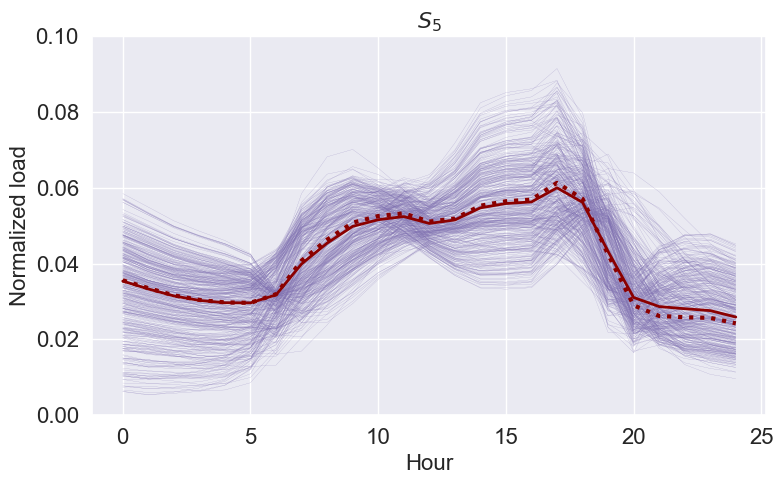

In [56]:
k = 4
fontsize = 16
abscissa = [float(x) for x in X.columns]
# source_colors = [colors[np.nonzero(A[k, :])[0][0]] for k in range(n_components)]
source_colors = colors

fig, ax = plt.subplots(figsize=(8, 5))
for i in range(N_opt):
    line, = ax.plot(abscissa, S_opt[k, :, i], linewidth=0.1, color=colors[k])
ax.plot(abscissa, geometric_median(S_opt[k, ...].T), linewidth=2, color='darkred')
ax.plot(abscissa, geometric_medoid(S_opt[k, ...].T), linewidth=3, linestyle='dotted', color='darkred')
ax.set_title(f"$S_{k + 1}$", fontsize=fontsize)
ax.set_xlabel('Hour', fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel('Normalized load', fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
plt.ylim((0, 0.1))
plt.tight_layout()

Visualise one solution with all sources together

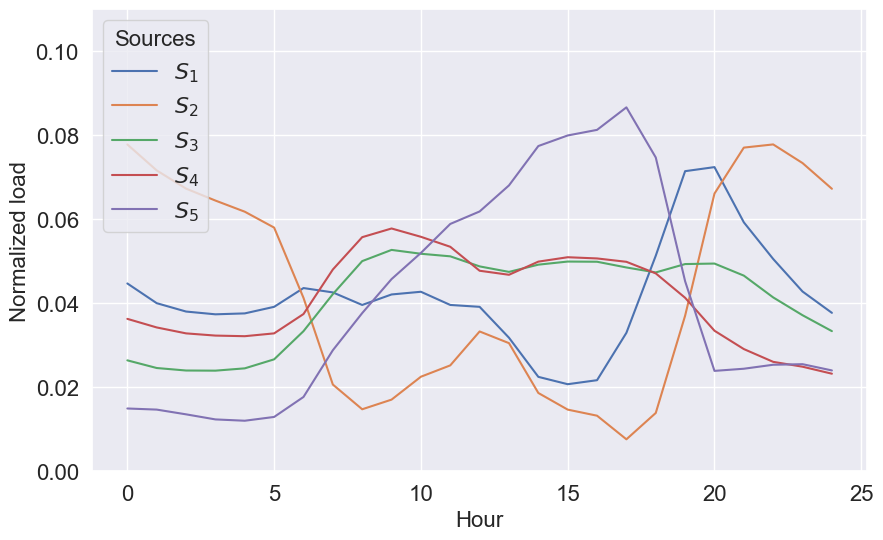

In [67]:
# Solution with minimum loss
solution = np.random.randint(0, N_opt)
fontsize = 16

S = S_opt[..., solution]
C = C_opt[..., solution]
fig, ax = plot_components(S)
ax.set_xlabel('Hour', fontsize=fontsize)  # X-axis label fontsize
ax.set_ylabel('Normalized load', fontsize=fontsize)  # Y-axis label fontsize
ax.tick_params(axis='both', which='major', labelsize=fontsize)  # X and Y ticks fontsize
# Add the legend
ax.legend(title='Sources', fontsize=fontsize, title_fontsize=fontsize, loc='upper left')
ylim = ax.set_ylim(bottom=0, top=0.11)

## Concentrations

In [68]:
nxN_opt_idx = pd.MultiIndex.from_product([X.index, range(N_opt)], names=["observation", "solution"])
C_df = pd.DataFrame(C_opt.transpose(0, 2, 1).reshape((n * N_opt, n_components)), columns=source_names, index=nxN_opt_idx)
C_df.reset_index(inplace=True)
C_df = C_df.merge(unit_info, left_on='observation', right_index=True)
C_df

,observation,solution,$S_1$,$S_2$,$S_3$,$S_4$,$S_5$,region,year,month,daytype,season
0,Italy_2020-01-01_Holiday,0,0.262810,0.185805,0.008793,0.256786,0.285327,Italy,2020,01,Holiday,Winter
1,Italy_2020-01-01_Holiday,1,0.197013,0.284600,0.007687,0.294027,0.216274,Italy,2020,01,Holiday,Winter
2,Italy_2020-01-01_Holiday,2,0.247628,0.204660,0.020236,0.310656,0.215962,Italy,2020,01,Holiday,Winter
3,Italy_2020-01-01_Holiday,3,0.227544,0.276040,0.035612,0.178118,0.281717,Italy,2020,01,Holiday,Winter
4,Italy_2020-01-01_Holiday,4,0.172589,0.248514,0.012364,0.279199,0.286733,Italy,2020,01,Holiday,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...
430723,Italy_2022-12-31_Saturday,388,0.235694,0.215756,0.113694,0.055562,0.378814,Italy,2022,12,Saturday,Fall
430724,Italy_2022-12-31_Saturday,389,0.334975,0.131446,0.082755,0.059137,0.391338,Italy,2022,12,Saturday,Fall
430725,Italy_2022-12-31_Saturday,390,0.295838,0.123598,0.008866,0.312810,0.258467,Italy,2022,12,Saturday,Fall
430726,Italy_2022-12-31_Saturday,391,0.302836,0.130133,0.087565,0.119400,0.359658,Italy,2022,12,Saturday,Fall


### Variability across solutions

Average concentration per day type

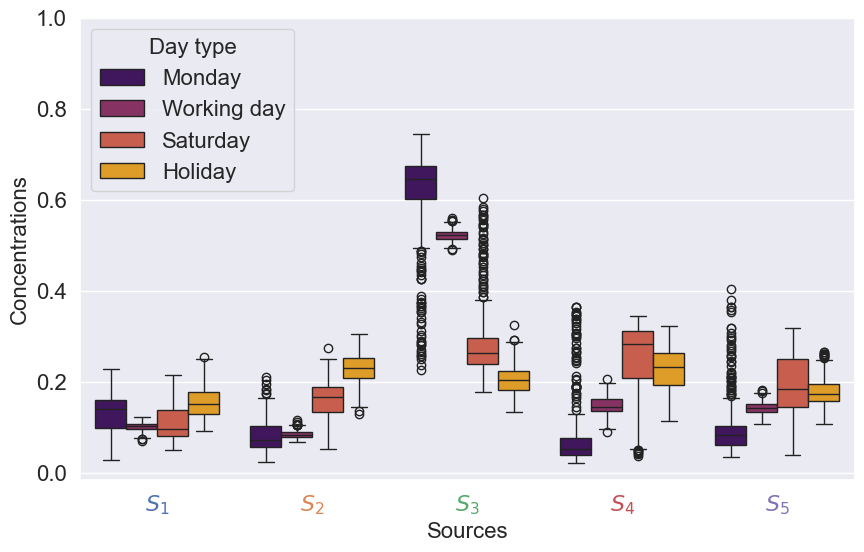

In [69]:
groupers = ['solution', 'daytype']
C_daytype = C_df.groupby(groupers, as_index=False)[source_names].mean()
C_daytype = C_daytype.melt(id_vars=groupers, var_name='Sources', value_name='Concentrations')

plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=C_daytype,
    x='Sources',
    y='Concentrations',
    hue='daytype',
    hue_order=daytype_order,
    palette='inferno'
)

ax.set_xlabel('Sources', fontsize=fontsize)
ax.set_ylabel('Concentrations', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(title='Day type', fontsize=fontsize, title_fontsize=fontsize, loc='upper left')

# Change the color of x-axis labels
for i, label in enumerate(ax.get_xticklabels()):
    label.set_color(colors[i])

plt.ylim(top=1)
plt.show()

Average concentration per month

2024-12-02 16:55:43,113 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-02 16:55:43,124 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


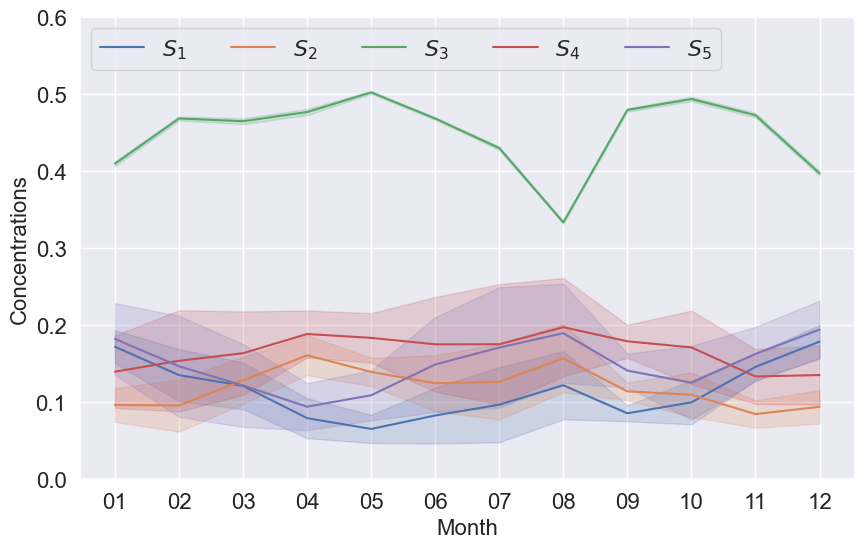

In [70]:
groupers = ['solution', 'month']
C_month = C_df.groupby(groupers, as_index=False)[source_names].mean()
C_month = C_month.melt(id_vars=groupers, var_name='Sources', value_name='Concentrations')

plt.figure(figsize=(10,6))

ax = sns.lineplot(
    data=C_month,
    x='month',
    y='Concentrations',
    hue='Sources',
    errorbar='sd',
)
ax.set_ylim(top=0.6, bottom=0)

ax.set_xlabel('Month', fontsize=fontsize)
ax.set_ylabel('Concentrations', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(title=None, fontsize=fontsize, title_fontsize=fontsize, loc='upper left', ncols=5)
plt.show()

Average concentration per season

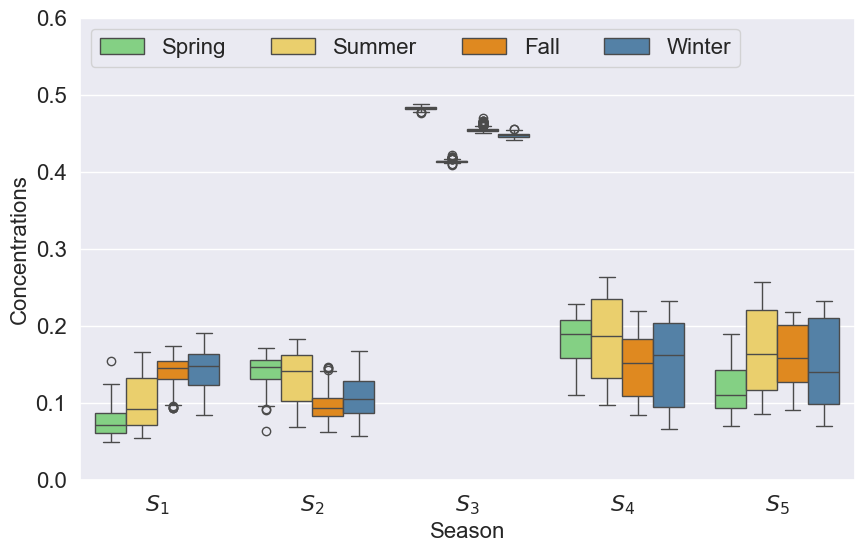

In [71]:
groupers = ['solution', 'season']
C_season = C_df.groupby(groupers, as_index=False)[source_names].mean()
C_season = C_season.melt(id_vars=groupers, var_name='Sources', value_name='Concentrations')

plt.figure(figsize=(10,6))

ax = sns.boxplot(
    data=C_season,
    x='Sources',
    y='Concentrations',
    hue='season',
    hue_order=season_order,
    palette=season_palette
)
ax.set_ylim(top=0.6, bottom=0)

ax.set_xlabel('Season', fontsize=fontsize)
ax.set_ylabel('Concentrations', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(title=None, fontsize=fontsize, title_fontsize=fontsize, loc='upper left', ncols=5)
plt.show()

### Variability across observations

In [72]:
C_sol = C_df.melt(id_vars=unit_info.columns.to_list() + ['solution', 'observation'], var_name='Sources', value_name='Concentrations')
C_sol

,region,year,month,daytype,season,solution,observation,Sources,Concentrations
0,Italy,2020,01,Holiday,Winter,0,Italy_2020-01-01_Holiday,$S_1$,0.262810
1,Italy,2020,01,Holiday,Winter,1,Italy_2020-01-01_Holiday,$S_1$,0.197013
2,Italy,2020,01,Holiday,Winter,2,Italy_2020-01-01_Holiday,$S_1$,0.247628
3,Italy,2020,01,Holiday,Winter,3,Italy_2020-01-01_Holiday,$S_1$,0.227544
4,Italy,2020,01,Holiday,Winter,4,Italy_2020-01-01_Holiday,$S_1$,0.172589
...,...,...,...,...,...,...,...,...,...
2153635,Italy,2022,12,Saturday,Fall,388,Italy_2022-12-31_Saturday,$S_5$,0.378814
2153636,Italy,2022,12,Saturday,Fall,389,Italy_2022-12-31_Saturday,$S_5$,0.391338
2153637,Italy,2022,12,Saturday,Fall,390,Italy_2022-12-31_Saturday,$S_5$,0.258467
2153638,Italy,2022,12,Saturday,Fall,391,Italy_2022-12-31_Saturday,$S_5$,0.359658


Concentrations per daytype

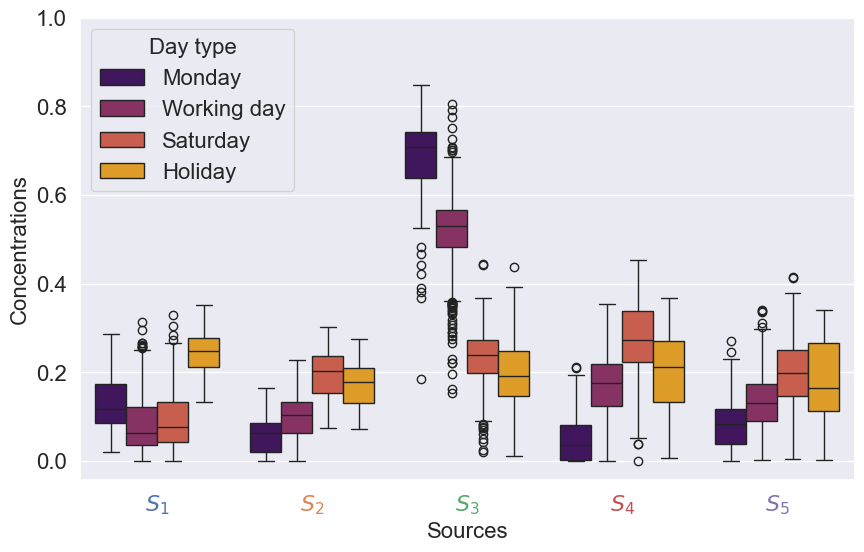

In [74]:
# We sample one solution
solution = np.random.randint(0, N_opt)

plt.figure(figsize=(10, 6))
ax = sns.boxplot(
    data=C_sol[C_sol.solution == solution],
    x='Sources',
    y='Concentrations',
    hue='daytype',
    hue_order=daytype_order,
    palette='inferno'
)

ax.set_xlabel('Sources', fontsize=fontsize)
ax.set_ylabel('Concentrations', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(title='Day type', fontsize=fontsize, title_fontsize=fontsize, loc='upper left')

# Change the color of x-axis labels
for i, label in enumerate(ax.get_xticklabels()):
    label.set_color(colors[i])
plt.ylim(top=1)
plt.show()

Concentrations per month

2024-12-02 16:56:24,038 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-12-02 16:56:24,045 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


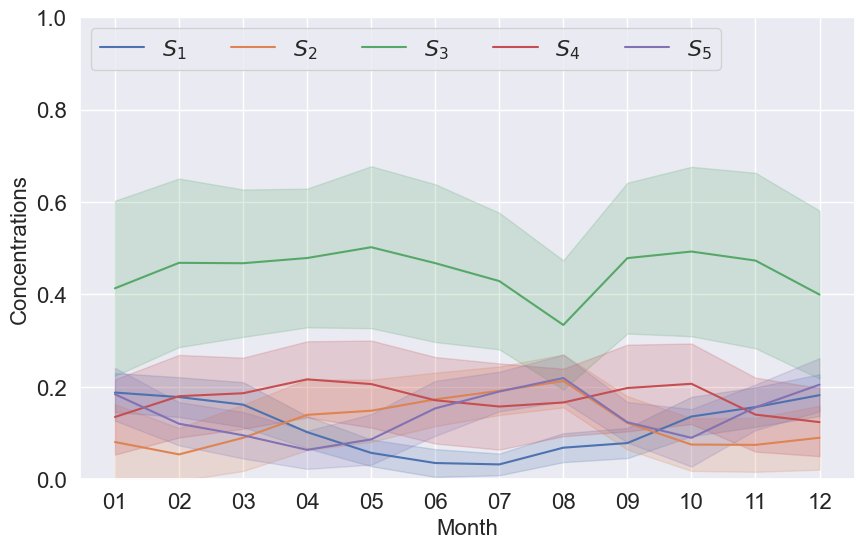

In [79]:
# We sample one solution
solution = np.random.randint(0, N_opt)

plt.figure(figsize=(10,6))

ax = sns.lineplot(
    data=C_sol[C_sol.solution == solution],
    x='month',
    y='Concentrations',
    hue='Sources',
    errorbar='sd',
)
ax.set_ylim(top=1, bottom=0)

ax.set_xlabel('Month', fontsize=fontsize)
ax.set_ylabel('Concentrations', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(title=None, fontsize=fontsize, title_fontsize=fontsize, loc='upper left', ncols=5)
plt.show()

Concentrations per season

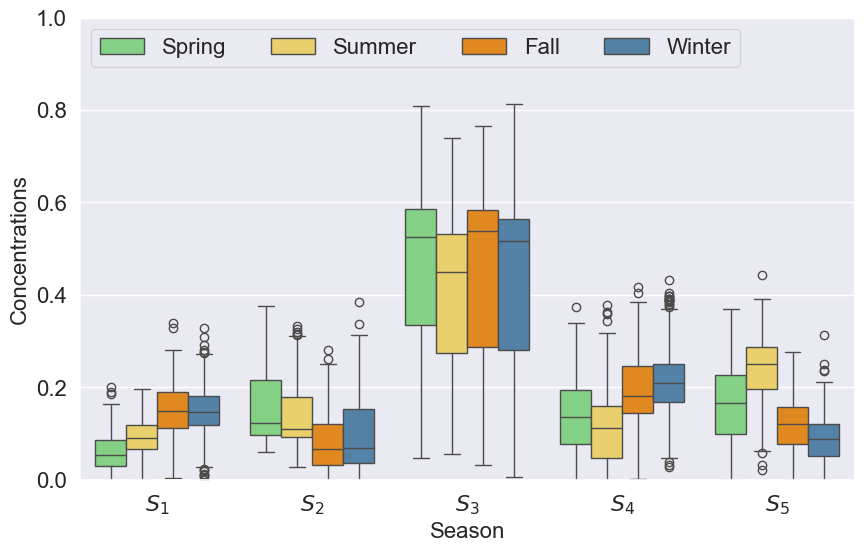

In [81]:
# We sample one solution
solution = np.random.randint(0, N_opt)

plt.figure(figsize=(10,6))

ax = sns.boxplot(
    data=C_sol[C_sol.solution == solution],
    x='Sources',
    y='Concentrations',
    hue='season',
    hue_order=season_order,
    palette=season_palette
)
ax.set_ylim(top=1, bottom=0)

ax.set_xlabel('Season', fontsize=fontsize)
ax.set_ylabel('Concentrations', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.legend(title=None, fontsize=fontsize, title_fontsize=fontsize, loc='upper left', ncols=5)
plt.show()

# Save optimal set of solutions

In [82]:
# Save all clean solutions
outfile_arrays = cluster_opt_path
outfile_estimators = outfile_arrays.replace('.npz', '.pkl')

np.savez(outfile_arrays, S_results=S_opt, C_results=C_opt)
print("Saved arrays at", outfile_arrays)
with open(outfile_estimators, 'wb') as file:
    pickle.dump(estimators_opt, file)
print("Saved estimators at", outfile_estimators)

Saved arrays at data/lcnmf_ens_opt_2020_to_2022.npz
Saved estimators at data/lcnmf_ens_opt_2020_to_2022.pkl


___

# TESTS